# Apriltag detection

Here, we provide some sample code for Apriltag detection and subsequent location estimation. First, we load the Fusiontest data, which has Apriltags within it.


In [1]:
from pyneon import get_sample_data, NeonDataset, NeonRecording

# Download sample data (if not existing) and return the path
sample_dir = "C:/Users/jan-gabriel.hartel/Documents/GitHub/PyNeon/data/FusionTest"
print(sample_dir)

dataset_dir = sample_dir
recording = NeonRecording(dataset_dir)

C:/Users/jan-gabriel.hartel/Documents/GitHub/PyNeon/data/FusionTest


Next, we provide the tag positions. In our case, the tags were placed in a rectangle on a whiteboard. We dfine the center of the whiteboard as our origin, with x pointing forward, y left and z up. We further provide the size of the printed tags. Using this information, the code calculates the camera position whenever at least one tag is detected

In [2]:
tag_locations = {
    0: [0.0, -0.25, 0.2],
    1: [0.0, 0.25, 0.2],
    2: [0.0, -0.25, -0.2],
    3: [0.0, 0.25, -0.2],
}

# Size of each tag (e.g., 0.2 meters, meaning 20 cm each side)
tag_size = 0.075

camera_position = recording.compute_camera_positions(tag_locations, tag_size)
print(camera_position.columns)

TypeCheckError: argument "tag_locations_df" (dict) is not an instance of pandas.core.frame.DataFrame

In [3]:
# plot the trajectory in xy

import matplotlib.pyplot as plt
import numpy as np

x = camera_position["camera_pos"].apply(lambda x: x[0]).values  # Extract x values
y = camera_position["camera_pos"].apply(lambda x: x[1]).values  # Extract y values
colors = np.arange(len(x))  # Create a color array based on the index

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=colors, cmap="viridis")
plt.colorbar(scatter, label="Index")
ax.set_aspect("equal", "box")
plt.show()

NameError: name 'camera_position' is not defined

We can further use Kalman filtering to obtain a more robust estimate of the current location, minimising the impact of errors

In [6]:
smoothed_camera_position = recording.smooth_camera_positions()

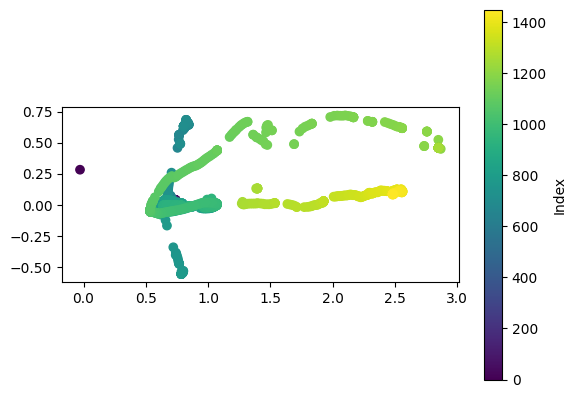

In [14]:
# plot the trajectory in xy

import matplotlib.pyplot as plt
import numpy as np

x = (
    camera_position["smoothed_camera_pos"].apply(lambda x: x[0]).values
)  # Extract x values
y = (
    camera_position["smoothed_camera_pos"].apply(lambda x: x[1]).values
)  # Extract y values
colors = np.arange(len(x))  # Create a color array based on the index

fig = plt.figure()
ax = fig.add_subplot(111)
scatter = ax.scatter(x, y, c=colors, cmap="viridis")
plt.colorbar(scatter, label="Index")
ax.set_aspect("equal", "box")
plt.show()